In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../../img"
import time

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Utility Function to Display Images
    :param img_arr : List of numpy array representing images
    :param r: Number of rows in the subplot
    :param c: Number of coloumns in the subplot
    :param dim: Figure Size of the subplot
    :param titles_arr: Title corresponding to each image in img_arr
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
def read_img(im_names):
    """
    Utitlity Function to Read Images from file
    :param im_names: Name of the image file in the images folder, directed using the IMAGES_FOLDER_PATH variable
    :return: Two seperate lists containing the colored and grayscale version of images as numpy array 
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [3]:
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'leaf.jpg',0)
def gen_tri(img,iters):
    """
    generates trimap given a matte or better quality tri-map
    :param img: 
    returns trimap 
    """
    kernel = np.ones((5,5),np.uint8)
    tri = cv2.erode(img,kernel,iterations = iters)

    for i in range(tri.shape[0]):
        for j in range(tri.shape[1]):
            if(tri[i][j]!=255 and tri[i][j]!=0):
                tri[i][j] = 127
    return tri

In [4]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'leaf.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'leaf.jpg'),0)
tri = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'leaf_tri.jpg'),0)


new_bg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg2.jpg'))
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)
new_bg = cv2.resize(new_bg, (img.shape[1],img.shape[0])) 

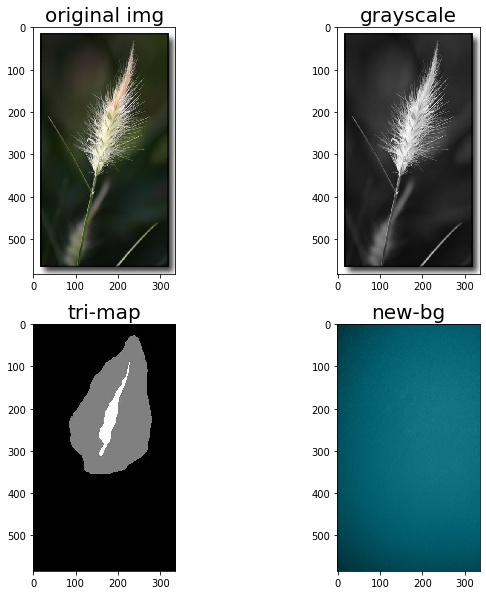

In [5]:
display_img_arr([img,img_gray,tri,new_bg], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



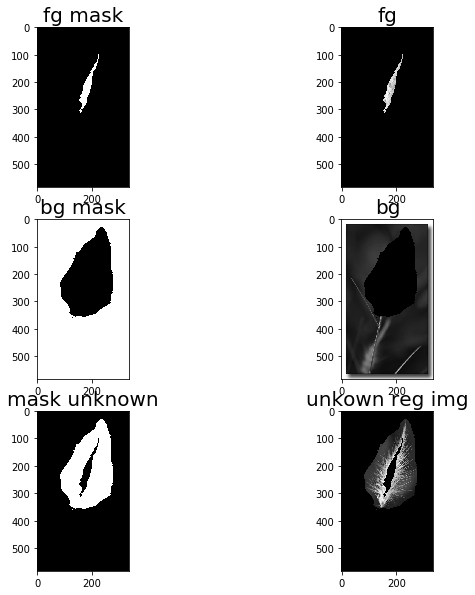

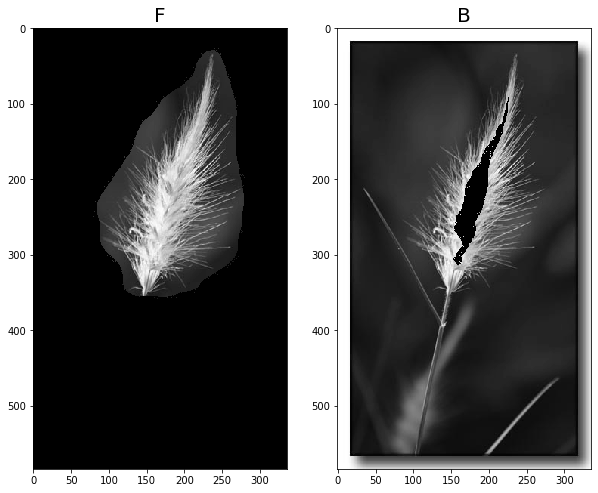

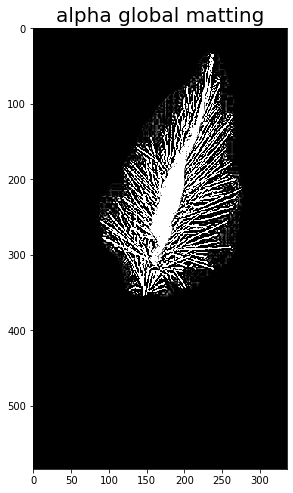

In [6]:
def calc_masks(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))

    fg = img_gray*(mask_fg)
    bg = img_gray*(mask_bg)
    unknown = img_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def doubleDifferential(img, factor):
    """
    Utility Function to Generate the Double Differential for the Poisson Equation
    :param img: A numpy array representing the Grayscale version of Image
    :param factor: A constant used to divide the first order differential before calculating the second order
                    differential. It can be a constant or a numpy array of the same size as img
    :returns : Two Numpy arrays representing the double differential in Y and X respectively
    """
    dy, dx = np.gradient(img)
    d2y, _ = np.gradient(dy/factor)
    _, d2x = np.gradient(dx/factor)
    return d2y, d2x
    
    
def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    F = img_gray*(mask_fg+mask_unknown)
    B = img_gray*(mask_bg+mask_unknown)
    return F, B

def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Implements Global Matting as discussed in the paper. Using image gradients, Approximate Foreground and Approximate 
    Background, it solves the Poisson Equation with the help of Gauss Siedel Approximation
    :param alpha: The Estimated value of Alpha for the Final Matte
    :param d2alpha: Sum of Double Differential in X and Y. Required to solve the Poisson Equation
    :param unknown_seg: A numpy array representing the pixels in the unknown region of the image/trimap
    :param iters: Number of Iterations the Gauss Siedel Approximation wil run
    :param threshold: If the amount of change happening after each iteration is below threshold, the program will end
    :param beta: The Beta Factor involved in Gauss Siedel Approximation
    
    :returns :A numpy array representing Matte produced and time taken to calculate it 
    """
    tic = time.time()
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
    tac = time.time()                    
    return alpha, tac-tic

def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Finding the Gradient and Difference required for the Poisson Equation and 
    the Estimate Alpha for Global Mating
    :param F: A numpy array representing Approximate Foreground 
    :param B: A numpy array representing Approximate Background 
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
   
    :returns :A numpy array representing the estimate alpha, A numpy array representing Double Differential
               A numpy array representing the difference of Approximate Foreground and Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri, img_gray):
    """
    Main Function to calculate the estimate alpha
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

def matting_combined(tri, img_gray):
    """
    Main Function to calculate the Matte
    """
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}

all_data = matting_combined(tri, img_gray)

all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])


# Alpha blending

### I = α F + (1 − α )B

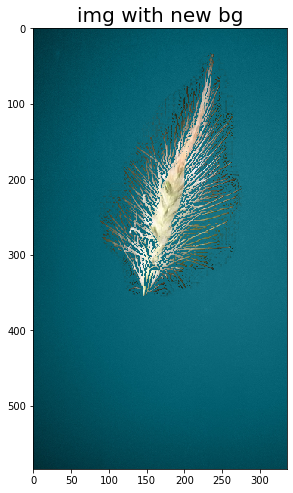

In [7]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

##  Computationally efficient version of Global alpha matting

In [10]:
def optimal_alpha_matting(alpha, d2alpha, unknown):
    tic = time.time()
    new_alpha = alpha.copy()
    old_alpha = np.zeros(alpha.shape)
    h, w = img_gray.shape
    threshold = 0.001
    iters = 50
    non_zero = np.nonzero(unknown)
    c_alpha = np.transpose(non_zero)
    c = c_alpha[(c_alpha[:,0]>=1)&(c_alpha[:,0]<h-1)&(c_alpha[:,1]>=1)&(c_alpha[:,1]<w-1)]
    first = c[:,0]
    second = c[:,1]
    diff = np.sum(np.abs(new_alpha - old_alpha))
    for i in range(iters):
        old_alpha = new_alpha.copy()
        new_alpha[first,second] = new_alpha[first-1 ,second]
        new_alpha[first,second] = new_alpha[first,second] 
        new_alpha[first,second] += new_alpha[first,second-1]
        new_alpha[first,second] += old_alpha[first, second+1] 
        new_alpha[first,second] += old_alpha[first+1,second]
        new_alpha[first,second] -= d2alpha[first,second]
        new_alpha[first,second] *= 1/4
        diff = np.sum(np.abs(new_alpha - old_alpha))
        if(diff < threshold):
            break
    tac = time.time()
    return new_alpha, tac-tic

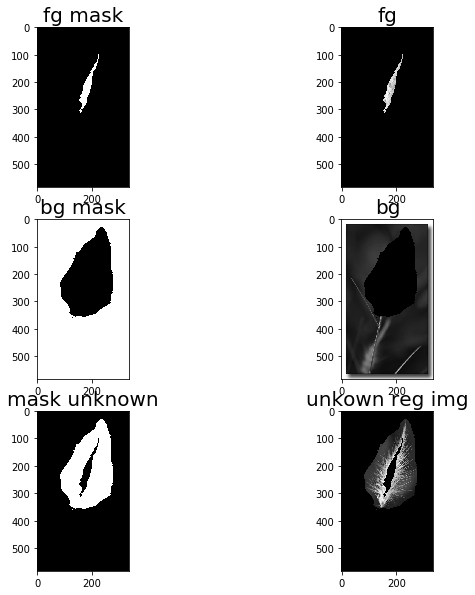

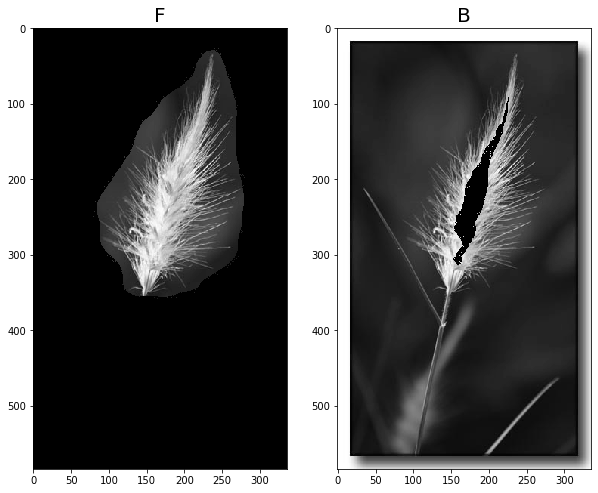

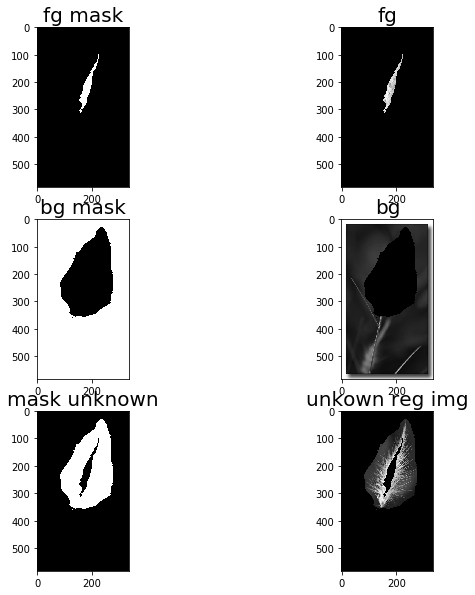

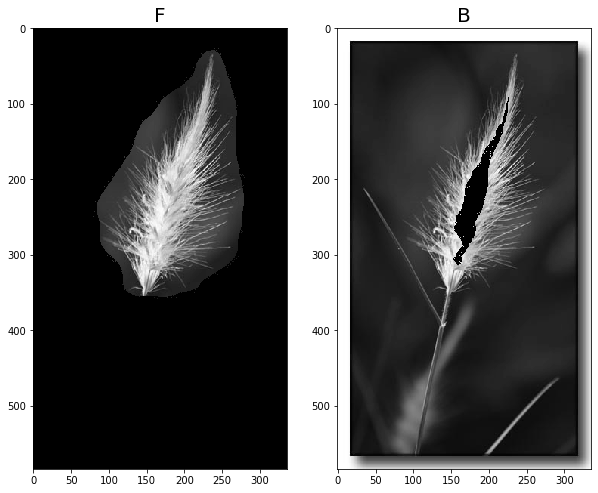

non-eff version time 16.40387487411499
eff version time 0.3213937282562256


In [11]:
import time
def matting(tri, img_gray,type_matting):
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    if(type_matting=='noneff'):
        alpha, time = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 50, threshold = 0.3, beta = 1.5)
    else:
        alpha, time = optimal_alpha_matting(estimate_alpha, d2alpha, mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)
    return alpha, time

alpha,time_non_eff = matting(tri, img_gray,'noneff')
alpha_o,time_o = matting(tri, img_gray,'eff')
print("non-eff version time",time_non_eff)
print("eff version time",time_o)

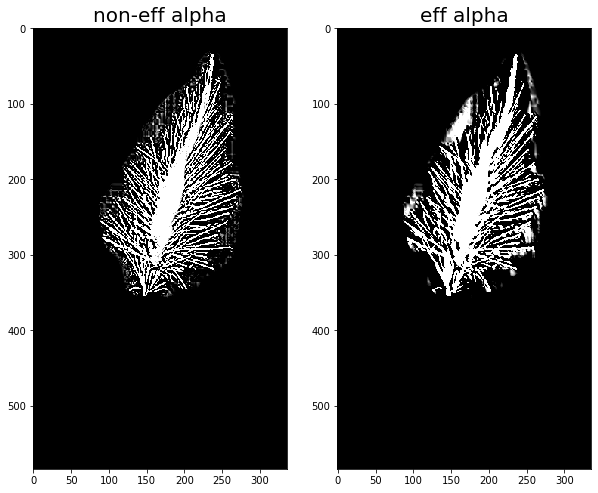

In [12]:
display_img_arr([alpha, alpha_o ], 1,2,(10,10),['non-eff alpha','eff alpha'])

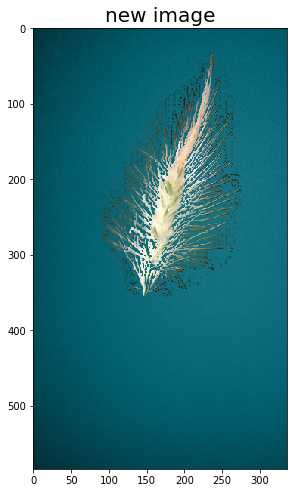

In [13]:
#alpha blending  
new_img_global = alpha_blend(new_bg,alpha,img )
display_img_arr([new_img_global], 1,2,(10,10),['new image'])

## Selecting Regions of Interest Interactively

In [14]:
# get ROI from Select_roi.py

!python3 Select_roi.py ../../img/leaf.jpg

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
(132, 74, 53, 60)


In [15]:
def read_coords():
    """
    Utility Function to read Coords selected and find the corner points of the ROI 
    """
    f = open('coords.txt','r')
    coords = f.read()
    f.close()
    # converting to int
    coord_int = []
    coords_i = coords.split(' ')
    for c in coords_i:
        if(c!=''):
            coord_int.append(int(c))
    return coord_int
coords =  read_coords() 
print(coords)
left, top,add_right, add_bottom = coords
right = left + add_right
bottom = top + add_bottom
print(top, bottom, left, right)

[132, 74, 53, 60]
74 134 132 185


## Diffusion Filtering

In [16]:
# !pip install medpy

In [17]:
from medpy.filter.smoothing import anisotropic_diffusion



![diffusion_params.png](../img/diffusion_params.png) 

In [19]:
img3 = img
def diffusion(img):
    """
    args: img
    returns new img which is to be passed in for further refinement
    """
    diffused_image = anisotropic_diffusion(img, niter=2, kappa=25, gamma=0.2, voxelspacing=None, option=1)
    ans = np.round(diffused_image)
#     final_ans = np.empty(img3.shape, dtype=int)
#     for k in range(3):
#         for i in range(ans.shape[0]):
#             for j in range(ans.shape[1]):
#                 final_ans[i, j, k] = int(ans[i, j, k])
    return ans

# img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'leaf.jpg'),0)
diffused_img3 = diffusion(img3)

# display_img_arr([img3,diffused_img3], 1,2,(10,10),['original img','diffusion filtered img'])
# img_float32 = np.float32(diffused_img3)
new_img_gray = cv2.cvtColor(diffused_img3, cv2.COLOR_RGB2GRAY)
all_data.update({'diffused_img': new_img_gray})


# display_img_arr([new_img_gray], 1,2,(10,10),['diffused gray image'])



/home/jayati/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/jayati/.local/lib/python3.6/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [20]:
## Local matting on diffused image
def local_matting(data_dic, top, bottom, left, right):
    """
    Local Matting functions which uses the Matte supplied by Global Matting and 
    Co-ordinates supplied by User to improve the Matte.
    :param data_dic: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    """
        
    h, w = data_dic['alpha'].shape[0], data_dic['alpha'].shape[1]
    local = 0
    if('local_matte' in data_dic.keys()):
        local = 1
        h, w = data_dic['local_matte'].shape[0], data_dic['local_matte'].shape[1]
        
    
    new_diff = data_dic['diff'][top:bottom+1, left:right+1]
    
    ## APPLYING GAUSSIAN FILTER ON THIS NEW DIFF
    new_diff = ndimage.filters.gaussian_filter(new_diff, 0.9)
    new_diff = np.minimum(np.maximum(new_diff,0),255)

    required_img= data_dic['diffused_img'].copy()[top:bottom+1, left:right+1]
    
    required_fg = data_dic['F'].copy()[top:bottom+1,left:right+1]
    required_bg = data_dic['B'].copy()[top:bottom+1,left:right+1]
    required_unknown = data_dic['unknown'].copy()[top:bottom,left:right]
    required_alpha= data_dic['alpha'].copy()[top:bottom+1,left:right+1]
    if(local==1):
        required_alpha= data_dic['local_matte'].copy()[top:bottom+1,left:right+1]
    
    required_inverted_alpha= 1 - required_alpha
    required_mask_unknown = data_dic['mask_unknown'].copy()[top:bottom+1, left:right+1]
    
    
    ## GET DOUBLE DIFFERENTIAL FOR IMG, FOREGROUND AND BACKGROUND
    fg_d2y, fg_d2x = doubleDifferential(required_fg, new_diff)
    bg_d2y, bg_d2x = doubleDifferential(required_bg, new_diff)
    img_d2y, img_d2x = doubleDifferential(required_img, new_diff)
    weighted_fg = required_alpha*(fg_d2x+fg_d2y)
    weighted_bg = required_alpha*(bg_d2x+bg_d2y)
    new_d2alpha = img_d2x + img_d2y - weighted_fg - weighted_bg

    matte, time = global_alpha_matting(required_alpha,new_d2alpha,required_mask_unknown, iters= 50, threshold = 0.1, beta = 0.2)

    matte = np.minimum(np.maximum(matte,0),1)


    return matte

In [21]:
all_data_2 = all_data.copy()

local_matte =  all_data_2['alpha'].copy()
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
all_data_2.update({'local_matte': local_matte})

# all_data_2['local_matte'] = local_matte

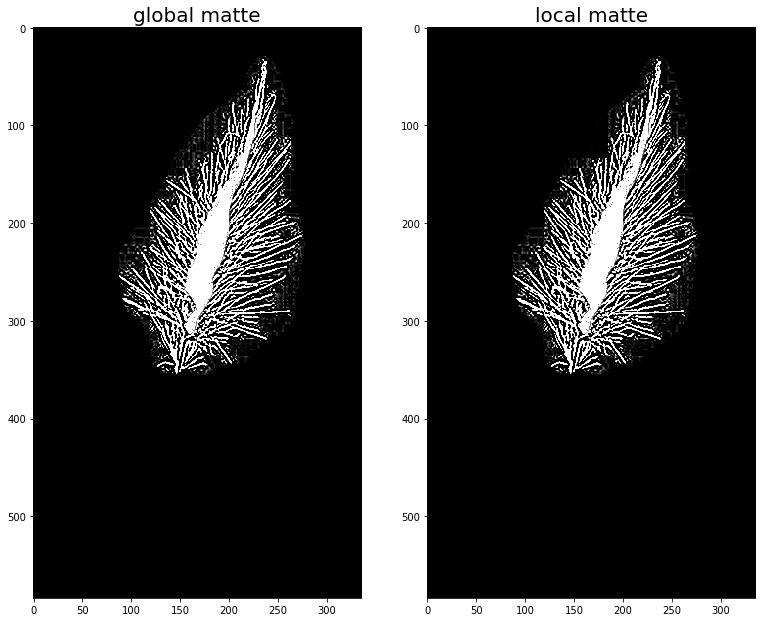

In [22]:
display_img_arr([all_data['alpha'], all_data_2['local_matte']], 1,3,(20,20),['global matte', 'local matte'])

In [87]:
### doing local matting again
# get ROI from Select_roi.py

!python3 Select_roi.py ../../img/leaf.jpg
all_data_2 = all_data.copy()
coords =  read_coords() 
print(coords)
left, top,add_right, add_bottom = coords
right = left + add_right
bottom = top + add_bottom
print(top, bottom, left, right)


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
(123, 98, 44, 61)
[123, 98, 44, 61]
98 159 123 167


In [88]:
# local_matte =  all_data_2['local_matte'].copy()
local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
# all_data_2['local_matte'] = local_matte
all_data_2.update({'local_matte': local_matte})


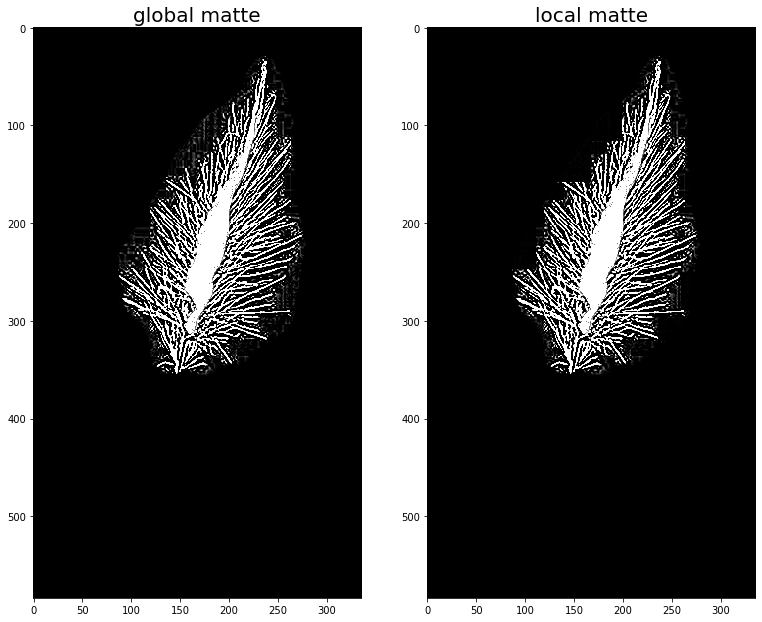

In [89]:
display_img_arr([all_data['alpha'], all_data_2['local_matte']], 1,3,(20,20),['global matte', 'local matte'])

In [27]:
### Local matting normal 

# def local_matting(data_dic, top, bottom, left, right):

#     h, w = data_dic['alpha'].shape[0], data_dic['alpha'].shape[1]
#     local = 0
#     if('local_matte' in data_dic.keys()):
#         local = 1
#         h, w = data_dic['local_matte'].shape[0], data_dic['local_matte'].shape[1]
        
    
#     new_diff = data_dic['diff'][top:bottom+1, left:right+1]
    
#     ## APPLYING GAUSSIAN FILTER ON THIS NEW DIFF
#     new_diff = ndimage.filters.gaussian_filter(new_diff, 0.9)
#     new_diff = np.minimum(np.maximum(new_diff,0),255)
    
#     ## EXTRACTING SEGMENTS IN GIVEN RANGE FOR ORIGINAL IMAGE, FOREGROUND AND THE BACKGROUND
#     required_img= data_dic['img_gray'].copy()[top:bottom+1, left:right+1]
#     required_fg = data_dic['F'].copy()[top:bottom+1,left:right+1]
#     required_bg = data_dic['B'].copy()[top:bottom+1,left:right+1]
#     required_unknown = data_dic['unknown'].copy()[top:bottom,left:right]
#     required_alpha= data_dic['alpha'].copy()[top:bottom+1,left:right+1]
#     if(local==1):
#         required_alpha= data_dic['local_matte'].copy()[top:bottom+1,left:right+1]
    
#     required_inverted_alpha= 1 - required_alpha
#     required_mask_unknown = data_dic['mask_unknown'].copy()[top:bottom+1, left:right+1]
    
    
#     ## GET DOUBLE DIFFERENTIAL FOR IMG, FOREGROUND AND BACKGROUND
#     fg_d2y, fg_d2x = doubleDifferential(required_fg, new_diff)
#     bg_d2y, bg_d2x = doubleDifferential(required_bg, new_diff)
#     img_d2y, img_d2x = doubleDifferential(required_img, new_diff)
#     weighted_fg = required_alpha*(fg_d2x+fg_d2y)
#     weighted_bg = required_alpha*(bg_d2x+bg_d2y)
#     new_d2alpha = img_d2x + img_d2y - weighted_fg - weighted_bg
    

# #     display_img_arr([data_dic['alpha']], 1,2,(10,10),['alpha'])
#     matte, time = global_alpha_matting(required_alpha,new_d2alpha,required_mask_unknown, iters= 50, threshold = 0.1, beta = 0.2)
# #     display_img_arr([data_dic['alpha'],data_dic['mask_unknown']], 1,2,(10,10),['alpha','mask unkwon'])
#     matte = np.minimum(np.maximum(matte,0),1)
    
    
# #     matte, _= optimal_alpha_matting(required_alpha, new_d2alpha, required_unknown)

#     return matte
# all_data_2 = all_data.copy()
# local_matte =  all_data_2['alpha'].copy()
# # print(local_matte.shape)

# # # selecting regions which we feel are not correct in matte
# top = 100
# bottom = 390
# left = 420 
# right = 450

# local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
# all_data_2['local_matte'] = local_matte

# display_img_arr([all_data['alpha']], 1,2,(10,10),['global matte'])

# # top,bottom,left,right = [400,420,90,110]
# # local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
# # top, bottom, left, right = [280, 400, 80, 100]
# # data_dic['alpha'] = local_matte
# # local_matte[top:bottom+1, left:right+1] = local_matting(data_dic, top, bottom, left, right)
    
# # local_matte = np.minimum(np.maximum(local_matte,0),1)
# display_img_arr([local_matte], 1,2,(10,10),['local matte'])

### Local Poisson Matting vs Global Matting 

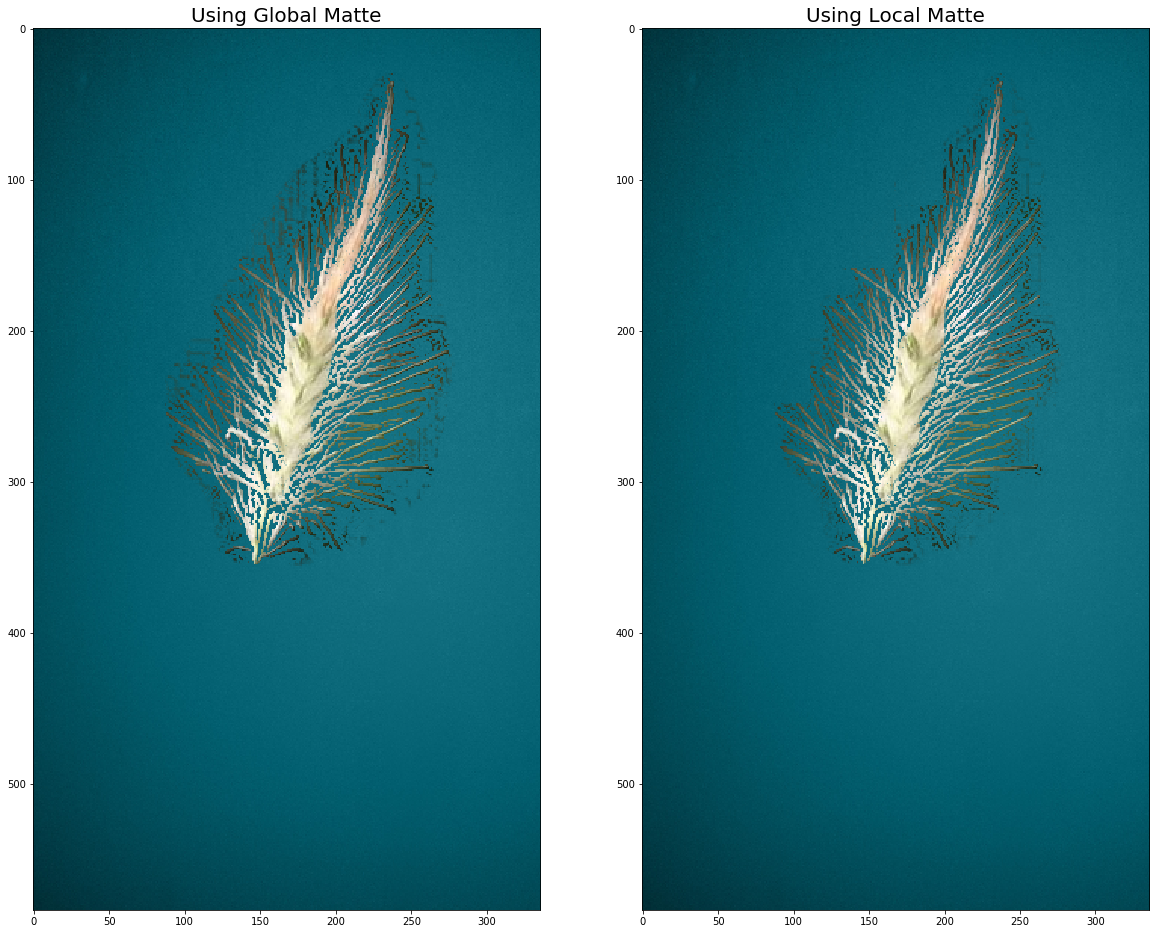

In [91]:
new_img_local = alpha_blend(new_bg,local_matte,img)
display_img_arr([new_img_global,new_img_local], 1,2,(20,20),['Using Global Matte', 'Using Local Matte'])
